# Assignment 1 - Task 2: Data Preparation and EDA

This notebook performs comprehensive EDA and data preparation on `datas/retail.csv` to support model building.

- Problem framing and goals
- Data profiling and cleaning
- Exploratory analysis and visuals
- Feature engineering
- Dataset splitting and artifact saving


In [1]:
# Imports
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)

from google.colab import drive
drive.mount('/drive')

DATA_PATH = Path('/drive/My Drive/Colab Notebooks/notebooks/data/retail.csv')
PROCESSED_DIR = Path('/drive/My Drive/Colab Notebooks/notebooks/data/processed')
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print('Using', DATA_PATH.resolve())


Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
Using /drive/My Drive/Colab Notebooks/notebooks/data/retail.csv


In [2]:
# Load dataset and basic info

df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
df.head()


Shape: (64532, 5)


,State,Industry,Series ID,Month,Turnover
0,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,1982 Apr,4.4
1,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,1982 May,3.4
2,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,1982 Jun,3.6
3,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,1982 Jul,4.0
4,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,1982 Aug,3.6


In [3]:
# Profiling summary

summary = {
    'columns': df.columns.tolist(),
    'dtypes': df.dtypes.astype(str).to_dict(),
    'num_rows': len(df),
    'num_cols': df.shape[1],
    'missing_perc': (df.isna().mean() * 100).round(2).to_dict()
}
summary


{'columns': ['State', 'Industry', 'Series ID', 'Month', 'Turnover'],
 'dtypes': {'State': 'object',
  'Industry': 'object',
  'Series ID': 'object',
  'Month': 'object',
  'Turnover': 'float64'},
 'num_rows': 64532,
 'num_cols': 5,
 'missing_perc': {'State': 0.0,
  'Industry': 0.0,
  'Series ID': 0.0,
  'Month': 0.0,
  'Turnover': 0.0}}

In [4]:
# Parse date column and coerce types

# Coerce month as datetime (format like '1982 Apr')
df['Month'] = pd.to_datetime(df['Month'], format='%Y %b', errors='coerce')

# Strip quotes in string columns if present
def strip_quotes(s):
    if isinstance(s, str) and len(s) >= 2 and s[0] == '"' and s[-1] == '"':
        return s[1:-1]
    return s

for col in ['State', 'Industry', 'Series ID']:
    df[col] = df[col].apply(strip_quotes).astype('category')

# Ensure numeric
df['Turnover'] = pd.to_numeric(df['Turnover'], errors='coerce')

# Re-profile after type fixes
df.dtypes


,0
State,category
Industry,category
Series ID,category
Month,datetime64[ns]
Turnover,float64


In [5]:
# Missing values and duplicates

missing_counts = df.isna().sum().sort_values(ascending=False)
dups = df.duplicated().sum()
missing_counts, {'duplicate_rows': int(dups)}


(State        0
 Industry     0
 Series ID    0
 Month        0
 Turnover     0
 dtype: int64,
 {'duplicate_rows': 0})

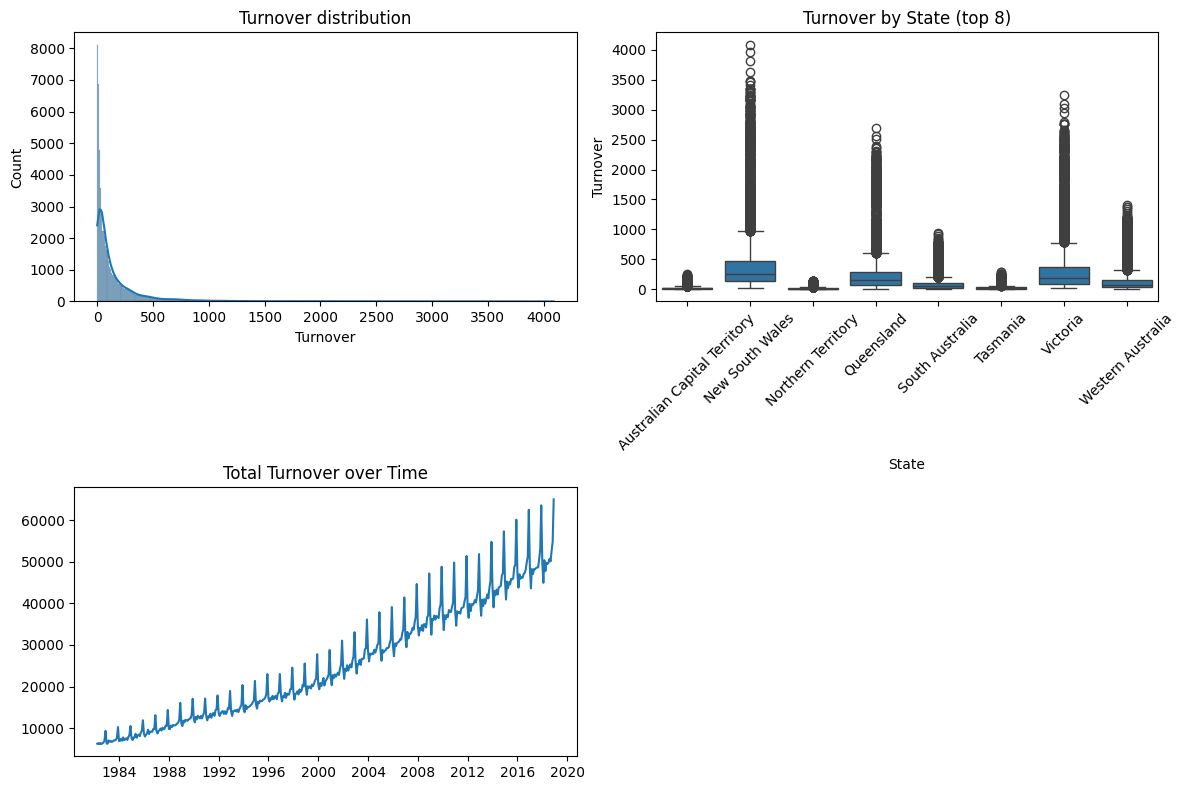

In [6]:
# Basic EDA: distributions and trends

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(df['Turnover'].dropna(), kde=True, ax=axes[0,0])
axes[0,0].set_title('Turnover distribution')

# Box by state (top 8 states if many)
state_counts = df['State'].value_counts().head(8).index
sns.boxplot(data=df[df['State'].isin(state_counts)], x='State', y='Turnover', ax=axes[0,1])
axes[0,1].set_title('Turnover by State (top 8)')
axes[0,1].tick_params(axis='x', rotation=45)

# Time trend overall
trend = df.groupby('Month', as_index=False)['Turnover'].sum()
axes[1,0].plot(trend['Month'], trend['Turnover'])
axes[1,0].set_title('Total Turnover over Time')

# Correlation among numeric (only Turnover here)
axes[1,1].axis('off')
plt.tight_layout()
plt.show()


In [7]:
# Cleaning steps: drop duplicates; simple imputation if needed

# Drop exact duplicates
df_clean = df.drop_duplicates().copy()

# If any missing in Month/Turnover, drop rows (few expected)
df_clean = df_clean.dropna(subset=['Month', 'Turnover'])

# Basic sanity: remove negative or zero turnover if any (domain-dependent)
df_clean = df_clean[df_clean['Turnover'] > 0]

print('After cleaning shape:', df_clean.shape)
df_clean.head(3)


After cleaning shape: (64532, 5)


,State,Industry,Series ID,Month,Turnover
0,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,1982-04-01,4.4
1,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,1982-05-01,3.4
2,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,1982-06-01,3.6


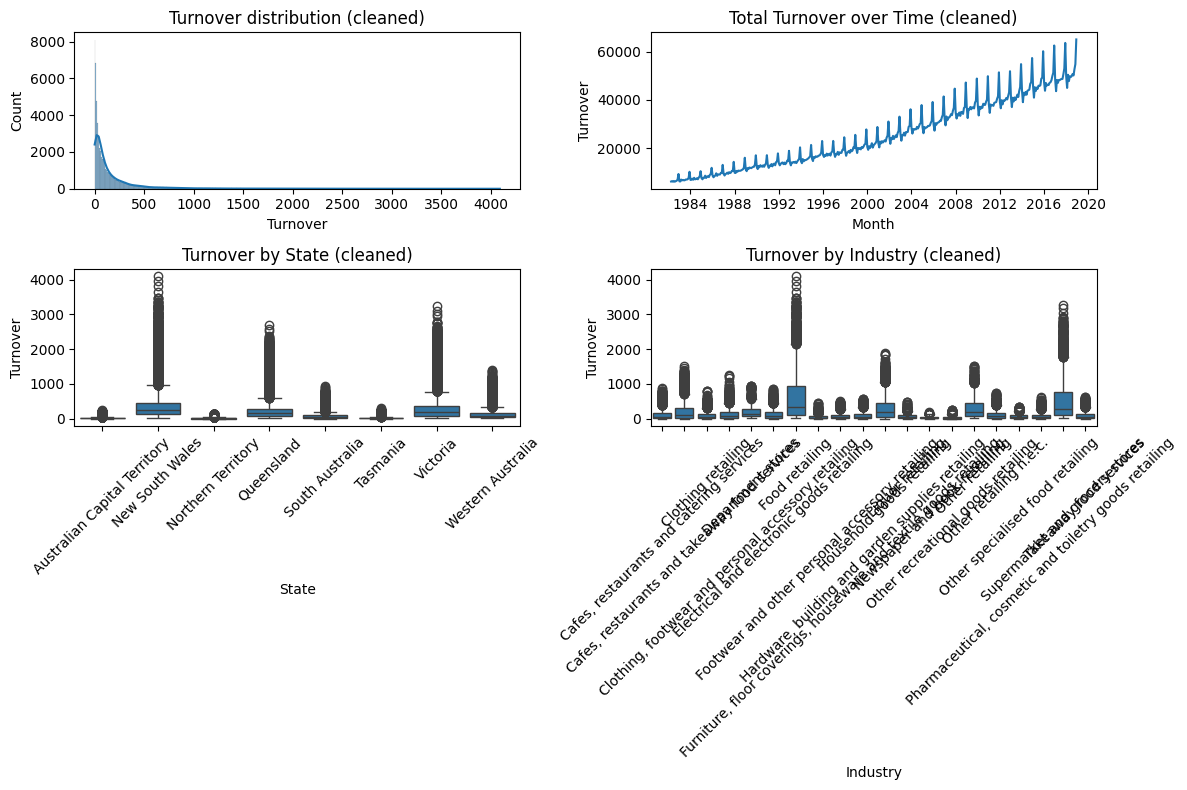

In [8]:
# Visuals on cleaned data

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(df_clean['Turnover'], kde=True, ax=axes[0,0])
axes[0,0].set_title('Turnover distribution (cleaned)')

sns.lineplot(data=df_clean.groupby('Month')['Turnover'].sum().reset_index(), x='Month', y='Turnover', ax=axes[0,1])
axes[0,1].set_title('Total Turnover over Time (cleaned)')

sns.boxplot(data=df_clean[df_clean['State'].isin(state_counts)], x='State', y='Turnover', ax=axes[1,0])
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].set_title('Turnover by State (cleaned)')

sns.boxplot(data=df_clean, x='Industry', y='Turnover', ax=axes[1,1])
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].set_title('Turnover by Industry (cleaned)')

plt.tight_layout()
plt.show()


In [9]:
# Feature engineering: date parts and group-level aggregations

fe = df_clean.copy()

# Date parts
fe['Year'] = fe['Month'].dt.year.astype('int16')
fe['MonthNum'] = fe['Month'].dt.month.astype('int8')
fe['Quarter'] = fe['Month'].dt.quarter.astype('int8')
fe['YearMonth'] = fe['Month'].dt.to_period('M').astype(str)

# Example: state-industry monthly totals
state_industry_month = (
    fe.groupby(['State', 'Industry', 'Month'], as_index=False)['Turnover']
      .sum()
      .rename(columns={'Turnover': 'Turnover_StateIndustry_Month'})
)

# Merge example back if needed (kept separate for clarity)
state_industry_month.head()


/tmp/ipython-input-2597507581.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fe.groupby(['State', 'Industry', 'Month'], as_index=False)['Turnover']


,State,Industry,Month,Turnover_StateIndustry_Month
0,Australian Capital Territory,"Cafes, restaurants and catering services",1982-04-01,4.4
1,Australian Capital Territory,"Cafes, restaurants and catering services",1982-05-01,3.4
2,Australian Capital Territory,"Cafes, restaurants and catering services",1982-06-01,3.6
3,Australian Capital Territory,"Cafes, restaurants and catering services",1982-07-01,4.0
4,Australian Capital Territory,"Cafes, restaurants and catering services",1982-08-01,3.6


In [10]:
# Preprocessing utilities (sklearn pipeline skeleton)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

numeric_features = ['Turnover']
categorical_features = ['State', 'Industry']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

preprocessor


ColumnTransformer(transformers=[('num', StandardScaler(), ['Turnover']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['State', 'Industry'])])

In [11]:
# Time-based split and saves (train/val/test by Month)

# Define chronological split: 70% train, 15% val, 15% test by unique months
months = np.sort(fe['Month'].unique())
train_end = int(0.7 * len(months))
val_end = int(0.85 * len(months))

train_months = set(months[:train_end])
val_months = set(months[train_end:val_end])
test_months = set(months[val_end:])

train_df = fe[fe['Month'].isin(train_months)].copy()
val_df = fe[fe['Month'].isin(val_months)].copy()
test_df = fe[fe['Month'].isin(test_months)].copy()

print('Split sizes:', len(train_df), len(val_df), len(test_df))

# Save to processed
train_df.to_csv(PROCESSED_DIR / 'train.csv', index=False)
val_df.to_csv(PROCESSED_DIR / 'val.csv', index=False)
test_df.to_csv(PROCESSED_DIR / 'test.csv', index=False)

print('Saved processed splits to', PROCESSED_DIR.resolve())


Split sizes: 44730 9884 9918
Saved processed splits to /drive/My Drive/Colab Notebooks/notebooks/data/processed
